<a id='home'></a>
### purpose

answer Q4 from the manuscript: How does the size of the dataset affect computational time and memory requirements?

### notes

- seff is a command-line slurm command that retrieves job data from a slurm job ID: `seff $SLURM_JOB_ID`
- I appended slurm job IDs to the stdout files from slurm jobs which I retrieve using custom code (of class `myslurm.Seffs`), which is a collection of individual job info (of class `myslurm.Seff`)

- the seffs returned for fitting jobs will say they all failed. This is because of the way the code was implemented - we did not use "marker_set" as a real variable, and so when the code tried to call one of the marker_set keys, it produced an error and killed the script. But this was only after calculating performance, which is what we care about. the creation of the unneeded figures that would come after the error would not be much more time.
- seffs include 20k jobs
- seffs include jobs that may not have completed

### outline

1. [get metadata](#meta)

1. [get training seffs](#seffs)

    we expect some failures from individual runs using 20k loci because of memory issues

   1. [combine training seffs](#cseffs)
   
   1. [make training figs](#tfigs)
   
       1. [plot training memory usage](#tmem)
   
       1. [plot training time usage](#ttime)
   
   1. [save training data](#tsave)
   
1. [get fitting seffs](#fseffs)
    
    we expect jobs to fail, but only after saving performance data (error for marker set not used)
    
   1. [combine fitting seffs](#cfseffs)
   
   1. [make fitting figs](#ffigs)
   
       1. [plot fitting memory usage](#fmem)

       1. [plot fitting time usage](#ftime)

   1. [save fitting data](#fsave)
   
1. [determine total computation times](#comp)

1. [determine processor information](#proc)

1. [end of notebook](#end)

In [1]:
from pythonimports import *
from myfigs import adjust_box_widths, jitter_fliers, save_pdf, histo_box

import MVP_summary_functions as mvp
import runtime_API as rt

import seaborn as sns

lview, dview = get_client(cluster_id='1726774874-jdp7', profile='lotterhos')

fig_dir = makedir(f'{rt.resdir}/figures/03_Q3_computational_requirements')

t0 = dt.now()  # notebook timer

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	September 19, 2024 - 16:30:52 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='meta'></a>
# get metadata

[top](#home)

In [2]:
source_colors = {}
for source in ['ind', 'pooled']:
    source_colors[source] = rt.boxplot_kwargs['palette'][source]

In [3]:
params = mvp.read_params_file()

params.head()

100%|███████████████| 2250/2250 [00:02<00:00, 876.39it/s]


,level,reps,arch,demog_name,demog_level_sub,demog_level,MIG_x,MIG_y,xcline,ycline,demog,METAPOP_SIDE_x,METAPOP_SIDE_y,Nequal,isVariableM,MIG_breaks,arch_level_sub,arch_level,MU_base,MU_QTL_proportion,SIGMA_QTN_1,SIGMA_QTN_2,SIGMA_K_1,SIGMA_K_2,N_traits,ispleiotropy,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel
1231094,highly-polygenic_1-trait__Est-Clines_N-cline-c...,1,highly-polygenic_1-trait,Est-Clines_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,4,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231094,0.500854,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_1-trait
1231095,highly-polygenic_1-trait__Est-Clines_N-cline-N...,1,highly-polygenic_1-trait,Est-Clines_N-cline-N-to-S_m-constant,N-cline-N-to-S_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,2,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231095,0.505075,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines_1-trait
1231096,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m_breaks,N-equal_m_breaks,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,1,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231096,0.499265,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-equal,m-breaks,Est-Clines_1-trait
1231097,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m-constant,N-equal_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231097,0.499365,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-equal,m-constant,Est-Clines_1-trait
1231098,highly-polygenic_1-trait__Est-Clines_N-variabl...,1,highly-polygenic_1-trait,Est-Clines_N-variable_m-variable,N-variable_m-variable,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,3,1,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231098,0.501054,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-variable,m-variable,Est-Clines_1-trait


In [4]:
params.plevel.unique()

array(['1-trait', '2-trait'], dtype=object)

In [5]:
# the 2-trait seeds that I want to keep, to use to filter out 1-trait 1-nuisance jobs
keep_seeds = params.seed.astype(str).iloc[:675][params.plevel == '2-trait']

assert len(keep_seeds) == (180 * 3)

<a id='seffs'></a>
# get training seffs

we expect some failures from individual runs using 20k loci because of memory issues

[top](#home)

In [6]:
seffs = wrap_defaultdict(dict, 3)
for (ind_or_pooled, rep), repdirs in unwrap_dictionary(rt.dirs):
    
    iop_text = ColorText(ind_or_pooled).bold().custom(source_colors[ind_or_pooled]).__str__()
    
    # get job info from each directory
    for repdir in repdirs:
        
        # print out colored dataset IDs
        num_loci = op.basename(repdir).lstrip('0')
        nltext = ColorText(num_loci).bold().custom(rt.boxplot_kwargs['palette'][num_loci])
        print(f'\n\n{iop_text} %s {nltext}' % ColorText(rep).bold())
        
        # find the std out files
        shdir = f'{repdir}/gradient_forests/training/training_shfiles'
        outs = fs(shdir, endswith='.out')
        
        # collect performance info for each out file with the `seff` slurm command`
        seffs[ind_or_pooled][rep][num_loci] = Seffs.parallel(lview, outs=outs).most_recent()
        
        # show the counts across jobs for completion state of job
        print(seffs[ind_or_pooled][rep][num_loci].states.counter())



ind run_20220919_0-225 500

Watching 227 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 227/227 [00:01<00:00, 138.74it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=227 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_0-225 5000

Watching 227 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 227/227 [00:01<00:00, 133.07it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_0-225 10000

Watching 244 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 244/244 [00:01<00:00, 139.54it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=244 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_0-225 20000

Watching 345 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 345/345 [00:02<00:00, 117.44it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=345 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 121, 'State: FAILED (exit code 137)': 91, 'State: FAILED (exit code 1)': 7, 'State: TIMEOUT (exit code 0)': 6})


ind run_20220919_225-450 500

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 139.43it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_225-450 5000

Watching 282 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 282/282 [00:02<00:00, 135.28it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=282 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_225-450 10000

Watching 281 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 281/281 [00:02<00:00, 134.04it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=281 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_225-450 20000

Watching 239 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 239/239 [00:01<00:00, 137.41it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=239 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 113, 'State: FAILED (exit code 137)': 99, 'State: FAILED (exit code 1)': 8, 'State: TIMEOUT (exit code 0)': 5})


ind run_20220919_450-675 500

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 139.12it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_450-675 5000

Watching 264 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 264/264 [00:02<00:00, 127.95it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=264 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_450-675 10000

Watching 330 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 330/330 [00:02<00:00, 126.63it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=330 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


ind run_20220919_450-675 20000

Watching 234 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 234/234 [00:01<00:00, 133.05it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=234 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 109, 'State: FAILED (exit code 137)': 106, 'State: FAILED (exit code 1)': 6, 'State: TIMEOUT (exit code 0)': 4})


pooled run_20220919_0-225 500

Watching 450 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 450/450 [00:03<00:00, 121.49it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=450 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_0-225 5000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 138.84it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_0-225 10000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 121.34it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_0-225 20000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 130.10it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_225-450 500

Watching 451 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 451/451 [00:03<00:00, 124.35it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=451 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_225-450 5000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 139.61it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_225-450 10000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 138.09it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=226 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_225-450 20000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 127.89it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_450-675 500

Watching 347 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 347/347 [00:02<00:00, 124.84it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=347 luni=225
  warnings.warn(text)


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_450-675 5000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 138.92it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_450-675 10000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 139.72it/s]


Counter({'State: COMPLETED (exit code 0)': 225})


pooled run_20220919_450-675 20000

Watching 227 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 227/227 [00:01<00:00, 131.55it/s]

Counter({'State: COMPLETED (exit code 0)': 225})


<a id='cseffs'></a>
## combine training seffs

[top](#home)

In [7]:
# get a list of dataframes containing computational and runtime info
training_dfs = []
for (ind_or_pooled, rep, num_loci), repseffs in unwrap_dictionary(seffs, progress_bar=True):
    rep_df = repseffs.to_dataframe(mem_units='MB', time_units='hrs')
    rep_df['source'] = ind_or_pooled  # add metadata
    rep_df['rep'] = rep  # add metadata
    rep_df['num_loci'] = num_loci  # add metadata
    training_dfs.append(rep_df)

# combine into a single dataframe
all_training_df = pd.concat(training_dfs)

# add more metadata
all_training_df['seed'] = all_training_df['sh'].apply(lambda sh: op.basename(sh).split("_")[0])

for param in params.columns[-9:]:
    all_training_df[param] = all_training_df.seed.map(params[param])

all_training_df['final_la_bin'] = all_training_df['final_LA'].apply(
    lambda la: '0.27 < LA ≤ 0.42' if la <= 0.42 else '0.42 < LA ≤ 0.58'
)

# remove 1-trait 1-nuisance performance
print(all_training_df.shape)
training_df = all_training_df[all_training_df.seed.isin(keep_seeds)].copy()
training_df['model'] = training_df['source'].apply(lambda source: 'geno-model' if source == 'ind' else 'af-model')
training_df.name = 'training'
print(training_df.shape)

training_df

100%|███████████████| 2/2 [00:20<00:00, 10.19s/it]

(5400, 28)
(4320, 29)


,slurm_job_id,nodes,cpus,core_walltime_hrs,cpu_efficiency,cpu_usage_hrs,memory_used_MB,memory_efficiency,memory_requested_MB,state,walltime_hrs,out,job,sh,source,rep,num_loci,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel,final_la_bin,model
40437730,40437730,1,1,0.124167,98.66%,0.1225,7823.36,15.64%,50001.92,State: COMPLETED (exit code 0),0.124167,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231109_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231109,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40437731,40437731,1,1,0.118056,98.35%,0.116111,6656.0,13.30%,50001.92,State: COMPLETED (exit code 0),0.118056,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231110_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231110,0.493447,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40437732,40437732,1,1,0.110556,99.25%,0.109722,6594.56,13.20%,50001.92,State: COMPLETED (exit code 0),0.110556,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231111_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231111,0.501673,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-equal,m-breaks,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40437733,40437733,1,1,0.117222,97.87%,0.114722,7116.8,14.24%,50001.92,State: COMPLETED (exit code 0),0.117222,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231112_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231112,0.497658,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-equal,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40437734,40437734,1,1,0.121667,97.26%,0.118333,8724.48,17.46%,50001.92,State: COMPLETED (exit code 0),0.121667,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231113_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231113,0.512199,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-variable,m-variable,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40811752,40811752,1,1,1.710833,99.95%,1.71,53790.72,29.88%,179998.72,State: COMPLETED (exit code 0),1.710833,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231764_GF_training_pooled_all,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231764,0.397212,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-center-to-edge,m-constant,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model
40811753,40811753,1,1,1.738889,99.92%,1.7375,59238.4,32.91%,179998.72,State: COMPLETED (exit code 0),1.738889,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231765_GF_training_pooled_all,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231765,0.389291,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model
40811754,40811754,1,1,1.94,99.94%,1.938889,80916.48,44.95%,179998.72,State: COMPLETED (exit code 0),1.94,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231766_GF_training_pooled_all,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231766,0.415404,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-equal,m-breaks,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model
40811755,40811755,1,1,1.143889,99.95%,1.143333,59463.68,33.03%,179998.72,State: COMPLETED (exit code 0),1.143889,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231767_GF_training_pooled_all,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231767,0.403683,oligogenic,2-trait,pleiotropy,uneq

In [8]:
len(training_df.index), luni(training_df.index)

(4320, 4320)

In [9]:
# how many years of training for all jobs?
all_training_df.walltime_hrs.sum() / (24 * 365)

2.0573438292744797

In [10]:
# how many years of training for 2-trait jobs?
training_df.walltime_hrs.sum() / (24 * 365)

1.6392037037037055

<a id='tfigs'></a>
## make training figs

[top](#home)

In [11]:
# # godzilla
# training_file = f'{fig_dir}/training_seff_df.txt'

# training_df = pd.read_table(training_file)
# training_df.name = 'training'

# training_df.head()

In [12]:
# there should be two instances of seed-numloci (one for ind one for pooled)
# the counts of `1` are jobs that finished by pooled but not by ind
Counter(Counter(training_df.index).values())

Counter({1: 4320})

### compare at individual vs population level

In [13]:
def cleanup_fig(g, y, ylabel, stage=None, x=None, hue=None, save=True, add_legend=True):
    """Make fig look rully good, save."""
    g.axes.set_ylabel(ylabel, fontsize=12)

    g.axes.set_xlabel(mvp.factor_names[x].replace('\n', ' '), fontsize=12)  # replace is for Selection\nStrength

    mvp.update_ticklabels(g, replace=[(' - ', '\n'), ('-cline-', '-cline\n')], fontsize=12)

    mvp.jitter_fliers(axes=[g.axes])

    adjust_box_widths(g)

    try:
        g.legend_.remove()
    except AttributeError:
        pass
    
    if add_legend is True:
        rt.add_legend(g.figure, color_by=hue, loc='center left', bbox_to_anchor=(1, 0.55))

    plt.tight_layout()
    
    if save is True:
        save_pdf(f'{fig_dir}/{stage}_{y}_{hue}_under_{x}.pdf')
    else:
        return

    plt.show()
    
    pass

In [14]:
def nest_hue_under_source(data, y='memory_used_MB', ylabel='Memory used (MB)'):
    for hue in rt.hue_order:
        if hue in ['noncausal_env', 'marker_set', 'program', 'demography', 'source']:
            continue

        g = sns.boxplot(
            data=data.astype({'memory_used_MB' : float, 'num_loci' : str}),
            y=y,
            x='model',
            order=['geno-model', 'af-model'],
            hue=hue,
            hue_order=rt.hue_order[hue],
            **rt.boxplot_kwargs
        )

        cleanup_fig(g, y, ylabel, data.name, x='source', hue=hue)

In [15]:
def nest_source_under_hue(data, y='memory_used_MB', ylabel='Memory used (MB)'):
    for hue in rt.hue_order:
        if hue in ['noncausal_env', 'marker_set', 'program', 'demography', 'source']:
            continue

        g = sns.boxplot(
            data=data.astype({'memory_used_MB' : float, 'num_loci' : str}),
            y=y,        
            x=hue,
            order=rt.hue_order[hue],
            hue='model',
            hue_order=['geno-model', 'af-model'],
            **rt.boxplot_kwargs
        )

        cleanup_fig(g, y, ylabel, data.name, x=hue, hue='model')

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_histo_box.pdf


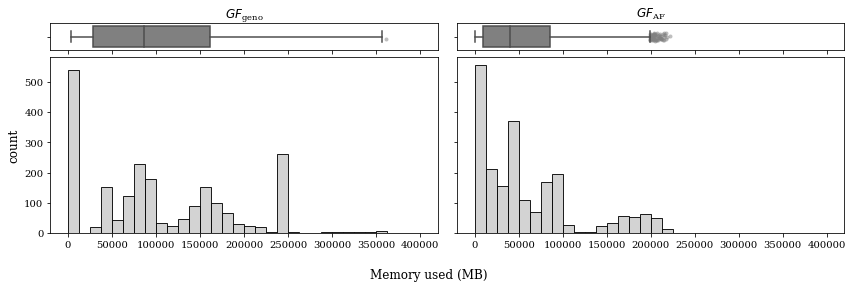

In [16]:
# memory histo boxes
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
for ax, source in zip(axes, ['ind', 'pooled']):
    ax_box, ax_hist = histo_box(
        training_df[training_df.source == source].memory_used_MB,
        ax=ax,
        histplot_kws=dict(
            facecolor='lightgray',
            binwidth=12500,
            binrange=(0, max(training_df.memory_used_MB) * 1.1)
        ),
        boxplot_kws=dict(color='gray')
    )

    ax_box.set_title(
        rt.factor_names['af-model'] if source == 'pooled' else rt.factor_names['geno-model'],
        fontsize=12
    )
    
    if source == 'ind':
        ax_hist.set_ylabel("count", fontsize=12)


fig.supxlabel("Memory used (MB)", fontsize=12)

plt.tight_layout()
    
save_pdf(f'{fig_dir}/training_memory_histo_box.pdf')

In [17]:
for source in ['ind', 'pooled']:
    df = training_df[training_df.source == source].copy()
    print(source, 'mem', df.memory_used_MB.mean(), df.memory_used_MB.median())
    print(source, 'time', df.core_walltime_hrs.mean(), df.core_walltime_hrs.median())

ind mem 103647.45007407418 86420.48000000001
ind time 4.637038580246921 2.6555555555555554
pooled mem 58165.9313148148 40192.0
pooled time 2.010843106995888 0.7545833333333334


Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_time_histo_box.pdf


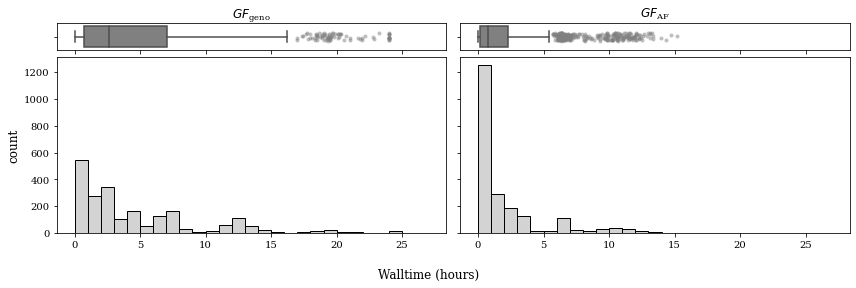

In [18]:
# time histo boxes
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
for ax, source in zip(axes, ['ind', 'pooled']):
    ax_box, ax_hist = histo_box(
        training_df[training_df.source == source].core_walltime_hrs,
        ax=ax,
#         xlim=(-1000, max(training_df.core_walltime_hrs) * 1.1),
        histplot_kws=dict(
            facecolor='lightgray',
            binwidth=1,
            binrange=(0, max(training_df.core_walltime_hrs) * 1.1)
        ),
        boxplot_kws=dict(color='gray')
    )

    ax_box.set_title(
        rt.factor_names['af-model'] if source == 'pooled' else rt.factor_names['geno-model'],
        fontsize=12
    )
    
    if source == 'ind':
        ax_hist.set_ylabel("count", fontsize=12)


fig.supxlabel("Walltime (hours)", fontsize=12)

plt.tight_layout()
    
save_pdf(f'{fig_dir}/training_time_histo_box.pdf')

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/None_memory_used_MB_None_under_source.pdf


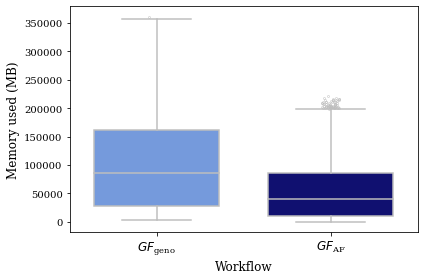

In [19]:
# direct compare mem
g = sns.boxplot(
    data=training_df,
    x='model',
    y='memory_used_MB',
    **rt.boxplot_kwargs
)

cleanup_fig(g, y='memory_used_MB', ylabel='Memory used (MB)', add_legend=False, x='source')


Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/None_core_walltime_hrs_None_under_source.pdf


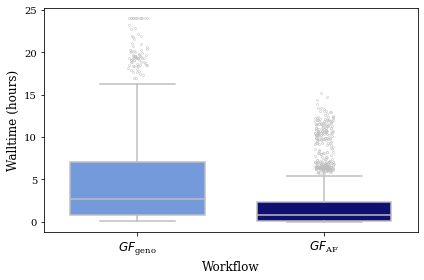

In [20]:
# direct compare time
g = sns.boxplot(
    data=training_df,
    x='model',
    y='core_walltime_hrs',
    **rt.boxplot_kwargs
)

cleanup_fig(g, y='core_walltime_hrs', ylabel='Walltime (hours)', add_legend=False, x='source')


<a id='tmem'></a>
### plot memory usage

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_landscape_under_source.pdf


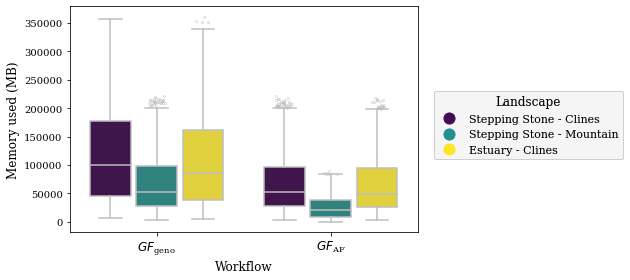

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_glevel_under_source.pdf


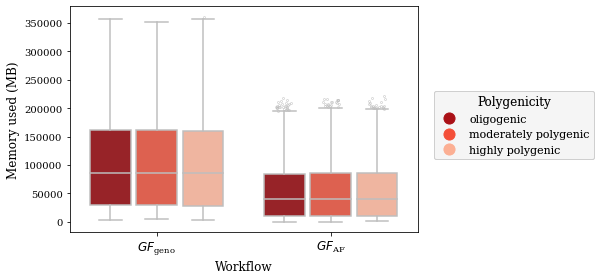

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_pleio_under_source.pdf


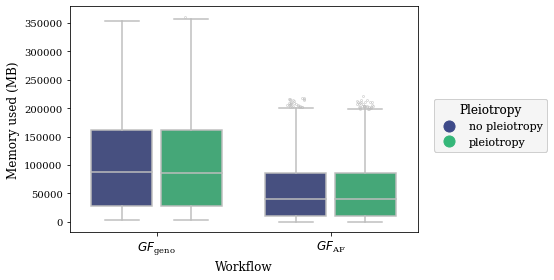

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_slevel_under_source.pdf


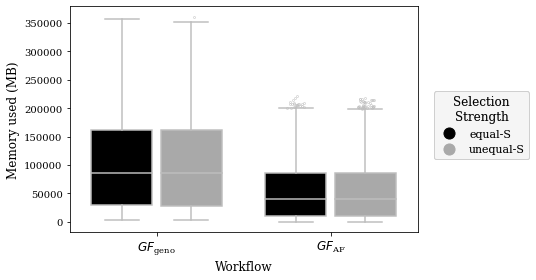

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_popsize_under_source.pdf


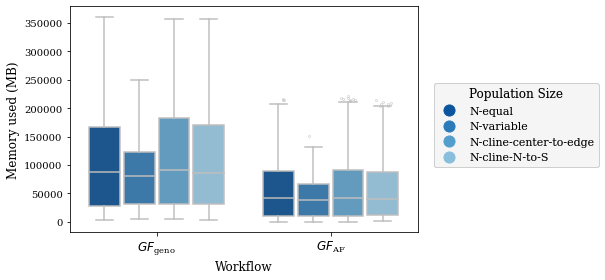

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_migration_under_source.pdf


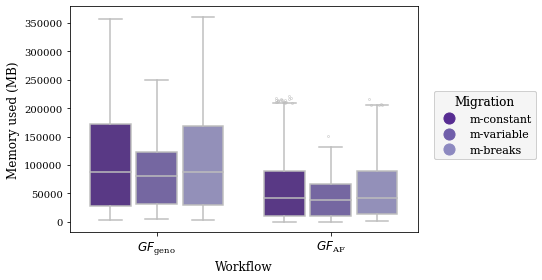

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_num_loci_under_source.pdf


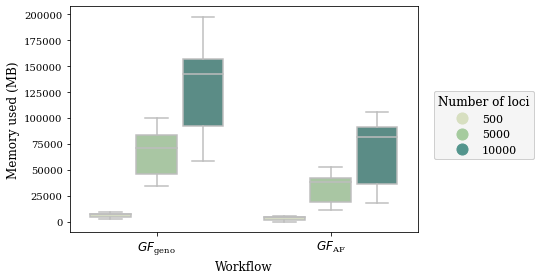

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_final_la_bin_under_source.pdf


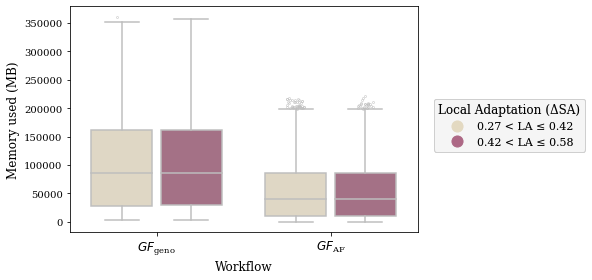

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_source.pdf


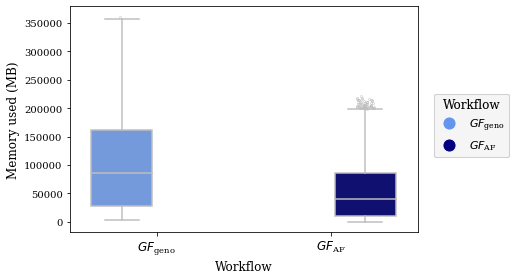

In [21]:
nest_hue_under_source(data=training_df)

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_landscape.pdf


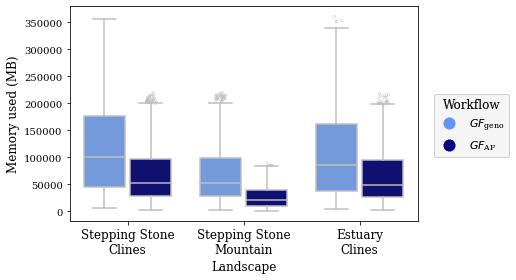

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_glevel.pdf


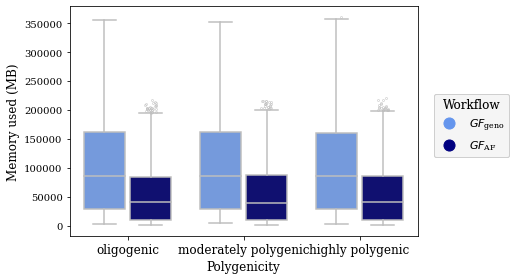

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_pleio.pdf


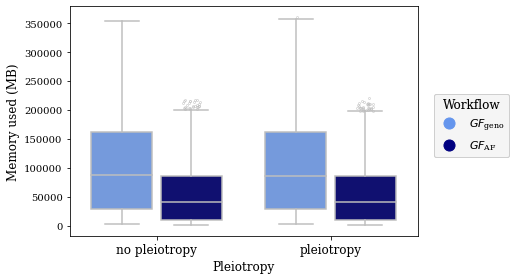

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_slevel.pdf


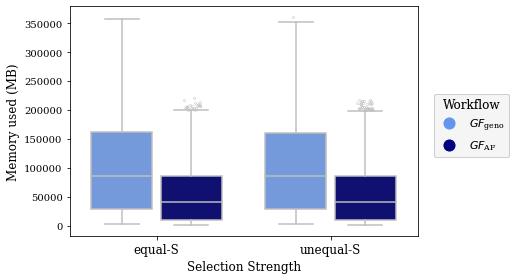

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_popsize.pdf


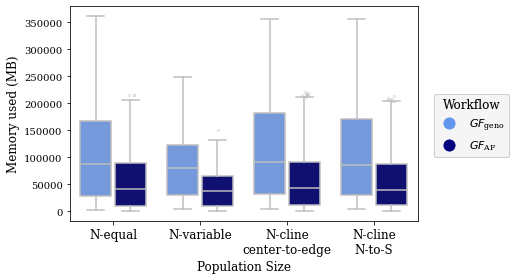

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_migration.pdf


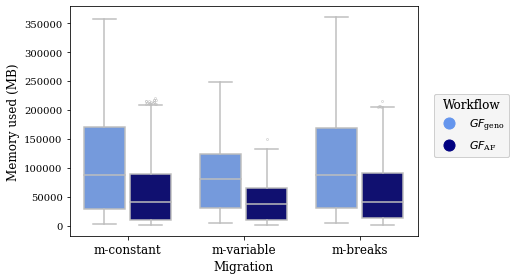

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_num_loci.pdf


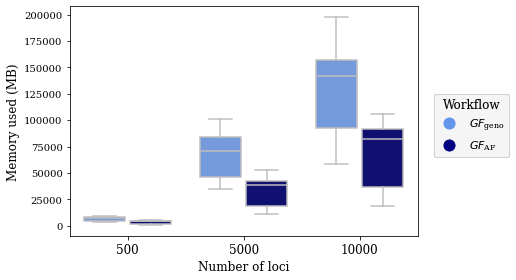

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_final_la_bin.pdf


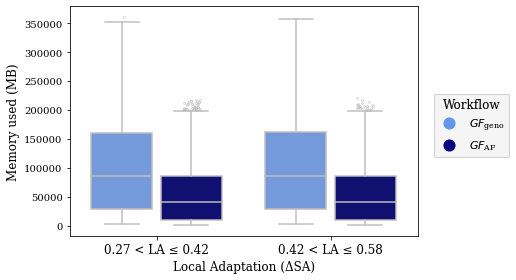

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_memory_used_MB_model_under_model.pdf


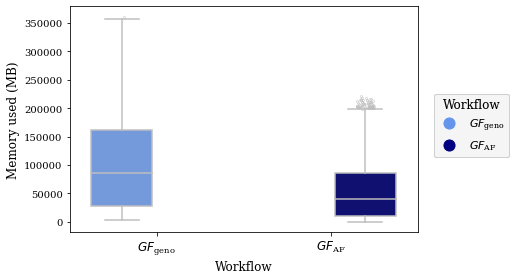

In [22]:
nest_source_under_hue(data=training_df)

<a id='ttime'></a>
### plot time usage

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_landscape_under_source.pdf


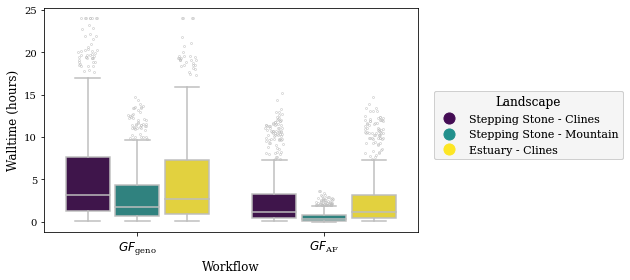

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_glevel_under_source.pdf


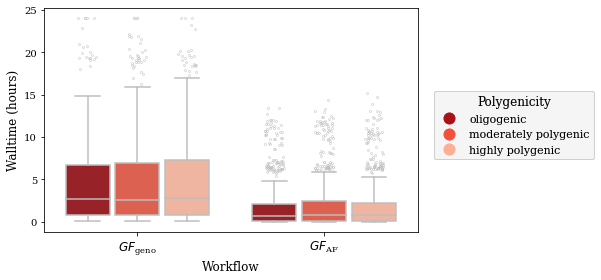

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_pleio_under_source.pdf


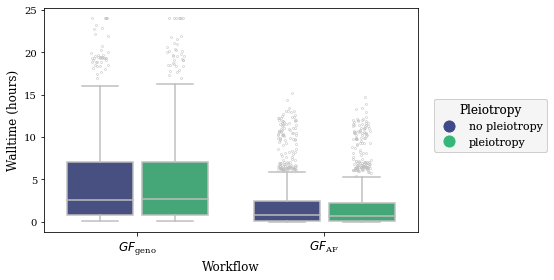

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_slevel_under_source.pdf


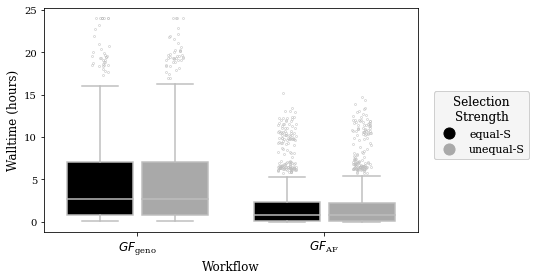

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_popsize_under_source.pdf


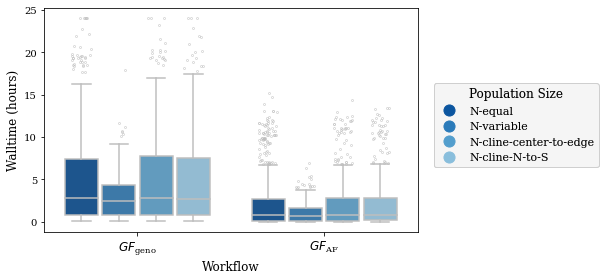

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_migration_under_source.pdf


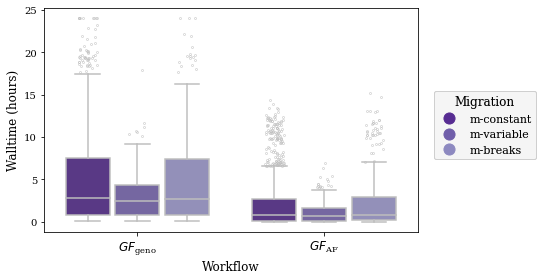

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_num_loci_under_source.pdf


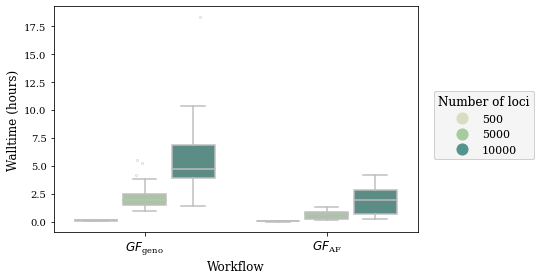

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_final_la_bin_under_source.pdf


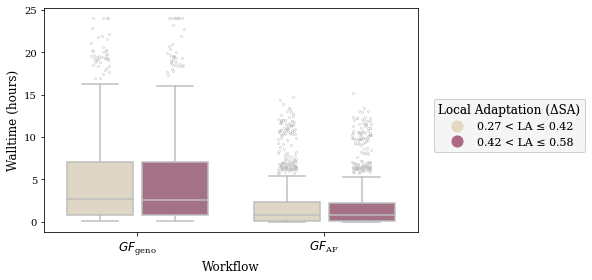

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_source.pdf


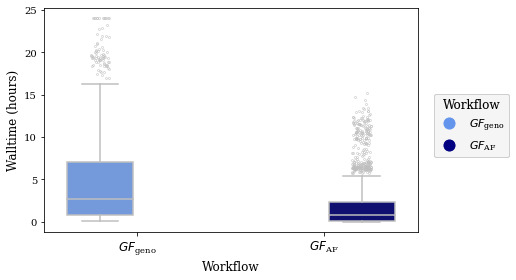

In [23]:
nest_hue_under_source(data=training_df, y='walltime_hrs', ylabel='Walltime (hours)')

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_landscape.pdf


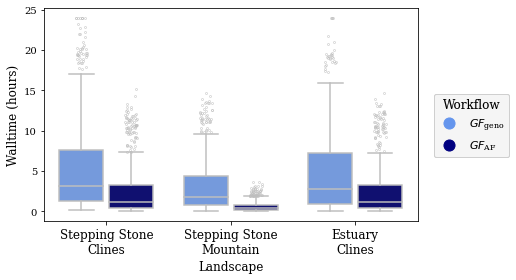

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_glevel.pdf


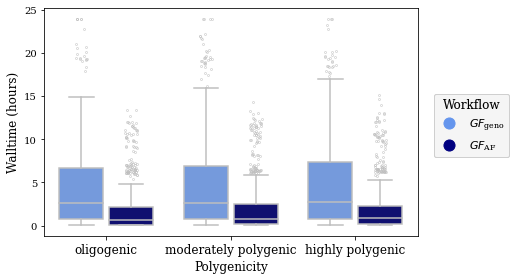

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_pleio.pdf


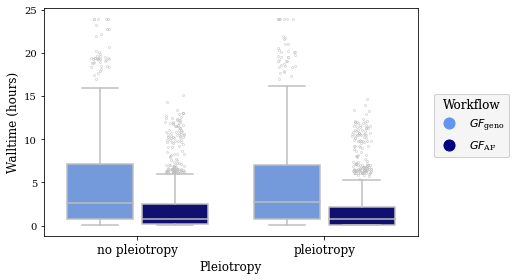

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_slevel.pdf


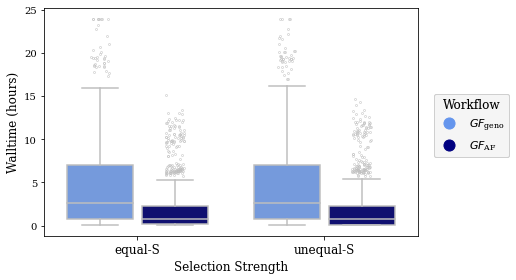

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_popsize.pdf


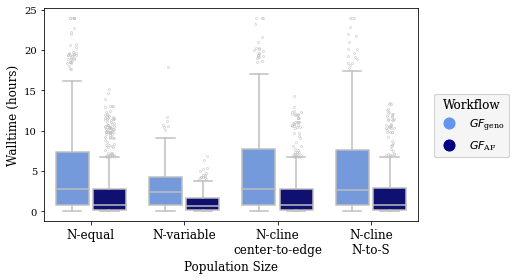

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_migration.pdf


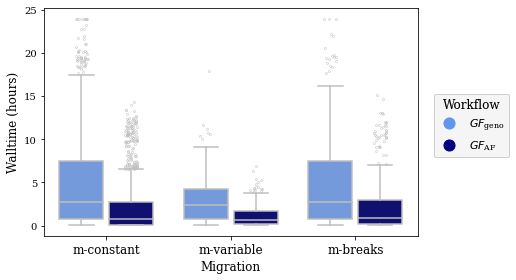

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_num_loci.pdf


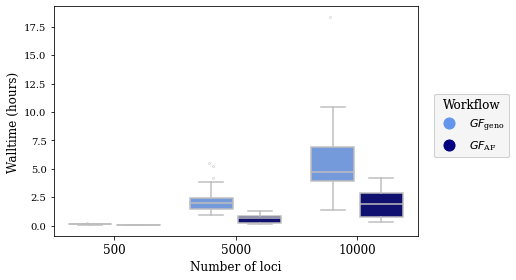

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_final_la_bin.pdf


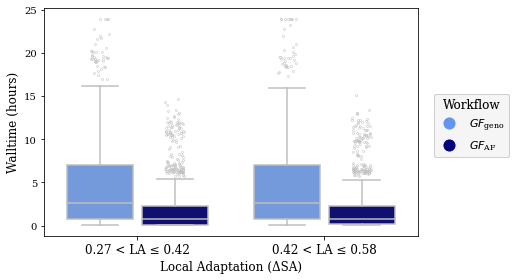

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_walltime_hrs_model_under_model.pdf


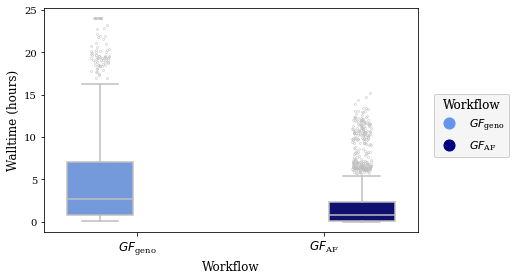

In [24]:
nest_source_under_hue(data=training_df, y='walltime_hrs', ylabel='Walltime (hours)')

## number of jobs attempted and completed

In [25]:
# number of training jobs attempted? A: all targeted jobs were attempted
for num_loci in training_df.num_loci.unique():
    ldf = training_df[training_df.num_loci == num_loci].copy()
    print(num_loci, Counter(ldf.seed.value_counts().values), Counter(ldf.source))

500 Counter({2: 540}) Counter({'ind': 540, 'pooled': 540})
5000 Counter({2: 540}) Counter({'ind': 540, 'pooled': 540})
10000 Counter({2: 540}) Counter({'ind': 540, 'pooled': 540})
20000 Counter({2: 540}) Counter({'ind': 540, 'pooled': 540})


In [26]:
ldf.state.unique()

array(['State: COMPLETED (exit code 0)', 'State: FAILED (exit code 1)',
       'State: FAILED (exit code 137)', 'State: TIMEOUT (exit code 0)'],
      dtype=object)

In [27]:
palette = rt.boxplot_kwargs['palette'].copy()

# number of training jobs completed? A: not all
for num_loci in training_df.num_loci.unique():
    for source in ['ind', 'pooled']:
        df = training_df[(training_df.num_loci == num_loci) & (training_df.source == source)].copy()
        print(
            ColorText(num_loci).custom(palette[num_loci]).bold(),
            ColorText(source).custom(source_colors[source]).bold(), '\n',
            df.state.value_counts(), '\n'
        )

500 ind 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 

500 pooled 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 

5000 ind 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 

5000 pooled 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 

10000 ind 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 

10000 pooled 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 

20000 ind 
 State: COMPLETED (exit code 0)    271
State: FAILED (exit code 137)     239
State: FAILED (exit code 1)        18
State: TIMEOUT (exit code 0)       12
Name: state, dtype: int64 

20000 pooled 
 State: COMPLETED (exit code 0)    540
Name: state, dtype: int64 



<a id='tsave'></a>
## save training data

[top](#home)

In [28]:
training_file = f'{fig_dir}/training_seff_df.txt'

training_df.to_csv(
    training_file,
    sep='\t',
    index=False,  # index is slurm_job_id
    header=True
)

training_file

'/work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_seff_df.txt'

In [29]:
# this includes the 1-trait 1-nuisance jobs
training_pkl = f'{fig_dir}/training_seffs.pkl'

pkldump(seffs, training_pkl)

training_pkl

'/work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_seffs.pkl'

<a id='fseffs'></a>
# fitting seffs

fitting jobs are expected to have failed, but only after saving performance data. see notes at top

[top](#home)

In [30]:
fitseffs = wrap_defaultdict(dict, 3)
for (ind_or_pooled, rep), repdirs in unwrap_dictionary(rt.dirs):
    iop_text = ColorText(ind_or_pooled).bold().custom(source_colors[ind_or_pooled]).__str__()
    
    # get job info from each directory
    for repdir in repdirs:
        
        # print out colored dataset IDs
        num_loci = op.basename(repdir).lstrip('0')
        nltext = ColorText(num_loci).bold().custom(rt.boxplot_kwargs['palette'][num_loci])
        print(f'\n\n{iop_text} %s {nltext}' % ColorText(rep).bold())
        
        # find the std out files
        shdir = f'{repdir}/gradient_forests/fitting/fitting_shfiles'
        outs = fs(shdir, endswith='.out')
        
        # retrieve performance info for each out file
        fitseffs[ind_or_pooled][rep][num_loci] = Seffs.parallel(lview, outs=outs).most_recent()
        
#         # show the counts across jobs for completion state of job
#         print(fitseffs[ind_or_pooled][rep][num_loci].states.counter())



ind run_20220919_0-225 500

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 130.27it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=226 luni=225
  warnings.warn(text)




ind run_20220919_0-225 5000

Watching 228 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 228/228 [00:01<00:00, 137.49it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=228 luni=225
  warnings.warn(text)




ind run_20220919_0-225 10000

Watching 230 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 230/230 [00:01<00:00, 136.36it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=230 luni=225
  warnings.warn(text)




ind run_20220919_0-225 20000

Watching 227 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 227/227 [00:01<00:00, 135.30it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=227 luni=224
  warnings.warn(text)




ind run_20220919_225-450 500

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 136.80it/s]




ind run_20220919_225-450 5000

Watching 234 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 234/234 [00:01<00:00, 136.34it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=234 luni=225
  warnings.warn(text)




ind run_20220919_225-450 10000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 136.16it/s]




ind run_20220919_225-450 20000

Watching 224 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 224/224 [00:01<00:00, 137.25it/s]




ind run_20220919_450-675 500

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 129.84it/s]




ind run_20220919_450-675 5000

Watching 245 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 245/245 [00:01<00:00, 127.34it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=245 luni=225
  warnings.warn(text)




ind run_20220919_450-675 10000

Watching 232 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 232/232 [00:01<00:00, 122.45it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=232 luni=225
  warnings.warn(text)




ind run_20220919_450-675 20000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 137.17it/s]
/home/b.lind/pythonimports/myslurm.py:560: UserWarning: There are multiple shfiles associated with outfiles. len=225 luni=224
  warnings.warn(text)




pooled run_20220919_0-225 500

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 122.08it/s]




pooled run_20220919_0-225 5000

Watching 228 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 228/228 [00:01<00:00, 134.96it/s]




pooled run_20220919_0-225 10000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 135.99it/s]




pooled run_20220919_0-225 20000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 134.94it/s]




pooled run_20220919_225-450 500

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 136.05it/s]




pooled run_20220919_225-450 5000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 128.79it/s]




pooled run_20220919_225-450 10000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 127.19it/s]




pooled run_20220919_225-450 20000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 135.58it/s]




pooled run_20220919_450-675 500

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 135.61it/s]




pooled run_20220919_450-675 5000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 132.52it/s]




pooled run_20220919_450-675 10000

Watching 225 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 225/225 [00:01<00:00, 129.90it/s]




pooled run_20220919_450-675 20000

Watching 226 parallel Seffs jobs ...


retrieving seffs: 100%|███████████████| 226/226 [00:01<00:00, 137.28it/s]


<a id='cfseffs'></a>
## combine fitting seffs

[top](#home)

In [31]:
# get a list of dataframes containing computational and runtime info
fitting_dfs = []
for (ind_or_pooled, rep, num_loci), repseffs in unwrap_dictionary(fitseffs, progress_bar=True):
    if len(repseffs) > 0 :
        rep_df = repseffs.to_dataframe(mem_units='MB', time_units='hrs')
        rep_df['source'] = ind_or_pooled  # add metadata
        rep_df['rep'] = rep  # add metadata
        rep_df['num_loci'] = num_loci  # add metadata
        fitting_dfs.append(rep_df)

# combine into a single dataframe
all_fitting_df = pd.concat(fitting_dfs)

# add more metadata
all_fitting_df['seed'] = all_fitting_df['sh'].apply(lambda sh: op.basename(sh).split("_")[0])

for param in params.columns[-9:]:
    all_fitting_df[param] = all_fitting_df.seed.map(params[param])
    
all_fitting_df['final_la_bin'] = all_fitting_df['final_LA'].apply(
    lambda la: '0.27 < LA ≤ 0.42' if la <= 0.42 else '0.42 < LA ≤ 0.58'
)

# keep only 2-trait jobs, exclude 1-trait 1-nuisance jobs
print(all_fitting_df.shape)
fitting_df = all_fitting_df[all_fitting_df.seed.isin(keep_seeds)].copy()
fitting_df['model'] = fitting_df['source'].apply(lambda source: 'geno-model' if source == 'ind' else 'af-model')
fitting_df.name = 'fitting'
print(fitting_df.shape)

fitting_df

100%|███████████████| 2/2 [00:20<00:00, 10.32s/it]

(5397, 28)
(4317, 29)


,slurm_job_id,nodes,cpus,core_walltime_hrs,cpu_efficiency,cpu_usage_hrs,memory_used_MB,memory_efficiency,memory_requested_MB,state,walltime_hrs,out,job,sh,source,rep,num_loci,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel,final_la_bin,model
40438417,40438417,1,7,0.254722,70.01%,0.178333,8120.32,2.71%,300001.28,State: FAILED (exit code 1),0.036389,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231109_gf_fitting,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231109,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40438418,40438418,1,7,0.243056,68.23%,0.165833,9236.48,3.08%,300001.28,State: FAILED (exit code 1),0.034722,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231110_gf_fitting,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231110,0.493447,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40438419,40438419,1,7,0.3325,70.09%,0.233056,8785.92,2.93%,300001.28,State: FAILED (exit code 1),0.0475,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231111_gf_fitting,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231111,0.501673,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-equal,m-breaks,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40438420,40438420,1,7,0.313056,72.32%,0.226389,10229.76,3.41%,300001.28,State: FAILED (exit code 1),0.044722,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231112_gf_fitting,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231112,0.497658,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-equal,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
40438421,40438421,1,7,0.303333,76.83%,0.233056,10608.64,3.54%,300001.28,State: FAILED (exit code 1),0.043333,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231113_gf_fitting,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231113,0.512199,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-variable,m-variable,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40930386,40930386,1,7,1.845278,92.49%,1.706667,63979.52,21.33%,300001.28,State: FAILED (exit code 1),0.263611,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231764_gf_fitting,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231764,0.397212,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-center-to-edge,m-constant,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model
40930589,40930589,1,7,1.876389,92.57%,1.736944,87336.96,29.11%,300001.28,State: FAILED (exit code 1),0.268056,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231765_gf_fitting,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231765,0.389291,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-cline-N-to-S,m-constant,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model
40930444,40930444,1,7,2.105833,93.19%,1.9625,95610.88,31.87%,300001.28,State: FAILED (exit code 1),0.300833,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231766_gf_fitting,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231766,0.415404,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-equal,m-breaks,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model
40930401,40930401,1,7,1.429167,90.65%,1.295556,62177.28,20.73%,300001.28,State: FAILED (exit code 1),0.204167,/work/lotterhos/brandon/pooled_runtimes/run_20...,1231767_gf_fitting,/work/lotterhos/brandon/pooled_runtimes/run_20...,pooled,run_20220919_450-675,20000,1231767,0.403683,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-equal,m-constant,SS-Mtn_unequal-S,0.27 < LA ≤ 0.42,af-model


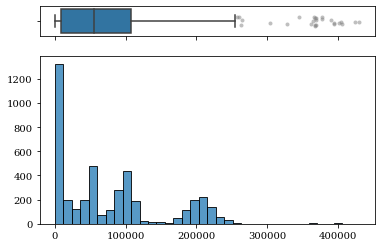

In [32]:
axes = histo_box(fitting_df.memory_used_MB)

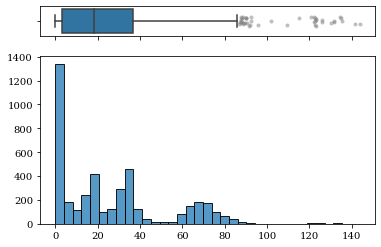

In [33]:
axes = histo_box(fitting_df.memory_efficiency.str.strip('%').astype(float))

In [34]:
# how many days of fitting?
fitting_df.walltime_hrs.sum() / 24

48.05674768518515

In [35]:
# how many days of fitting for 2-trait 0-nuisance + 1-trait 1-nuisance?
all_fitting_df.walltime_hrs.sum()

1445.645555555556

<a id='ffigs'></a>
## make fitting figs

[top](#home)

<a id='fmem'></a>
### plot memory usage

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_landscape_under_source.pdf


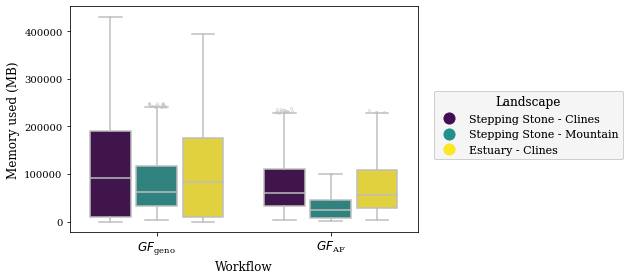

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_glevel_under_source.pdf


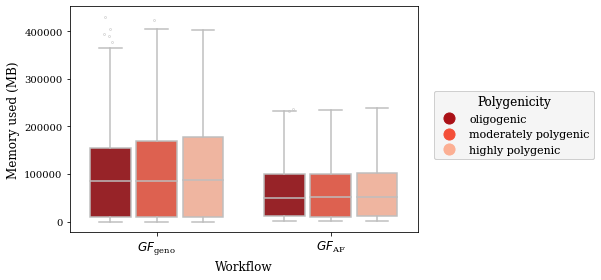

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_pleio_under_source.pdf


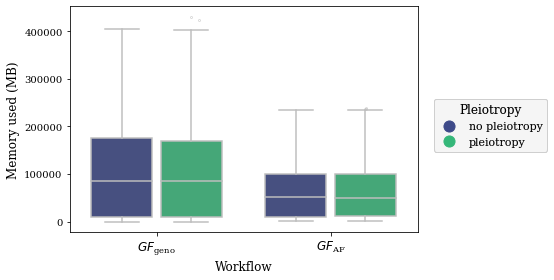

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_slevel_under_source.pdf


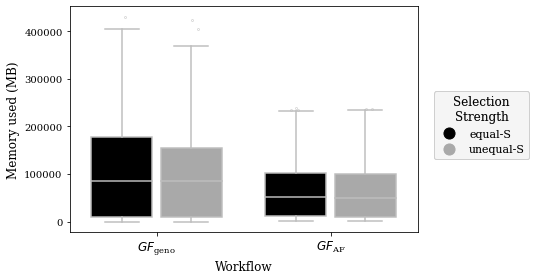

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_popsize_under_source.pdf


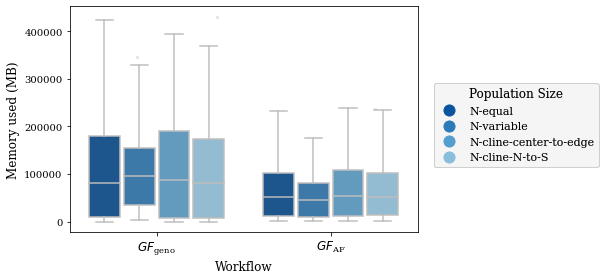

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_migration_under_source.pdf


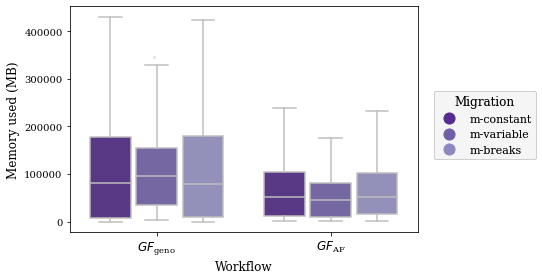

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_num_loci_under_source.pdf


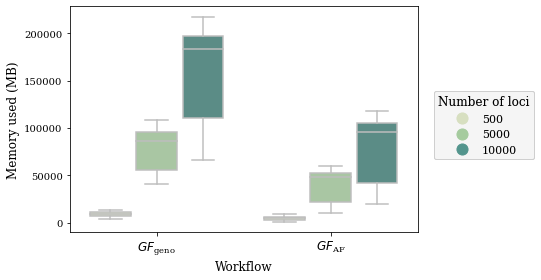

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_final_la_bin_under_source.pdf


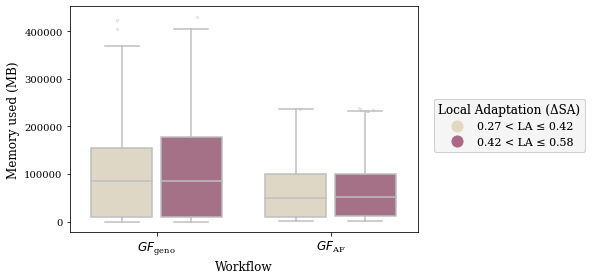

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_source.pdf


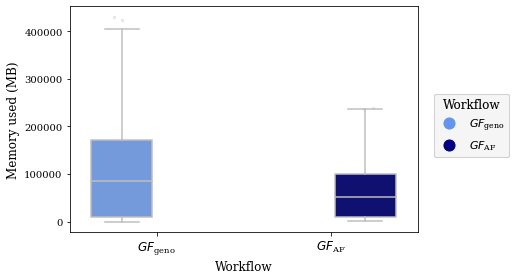

In [36]:
nest_hue_under_source(data=fitting_df)

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_landscape.pdf


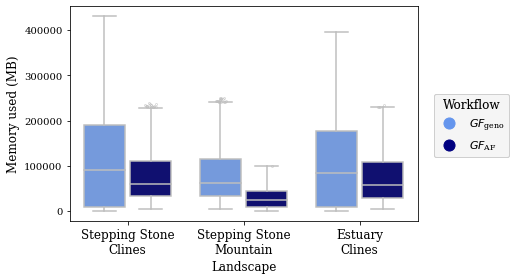

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_glevel.pdf


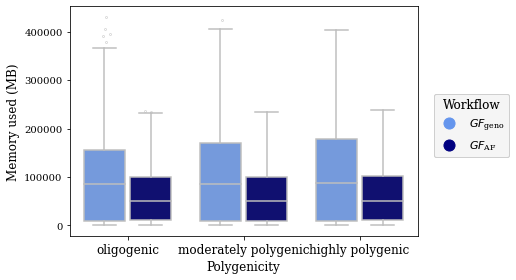

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_pleio.pdf


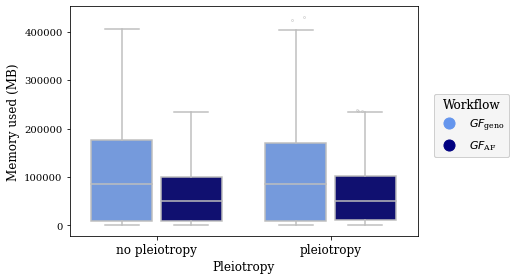

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_slevel.pdf


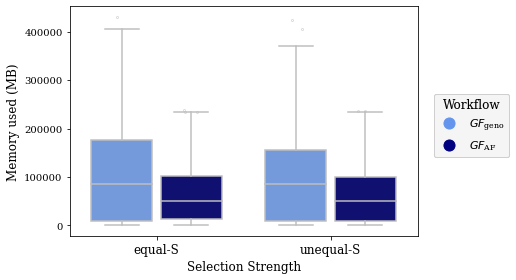

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_popsize.pdf


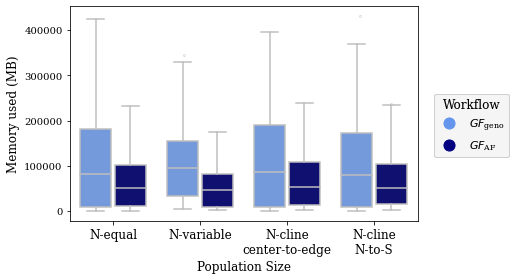

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_migration.pdf


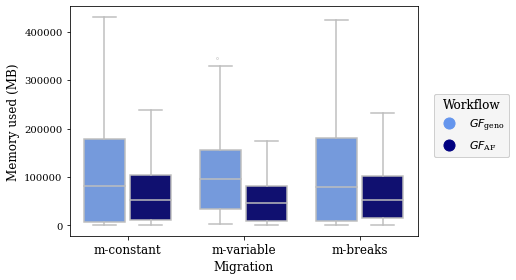

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_num_loci.pdf


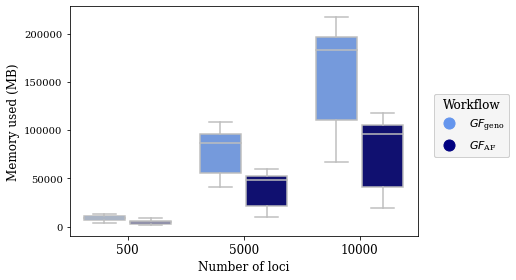

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_final_la_bin.pdf


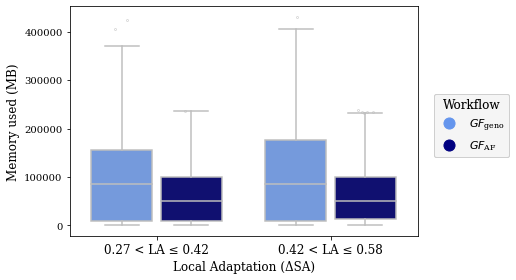

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_memory_used_MB_model_under_model.pdf


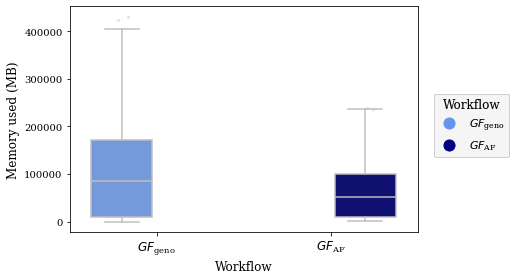

In [37]:
nest_source_under_hue(data=fitting_df)

<a id='ftime'></a>
### plot time usage

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_landscape_under_source.pdf


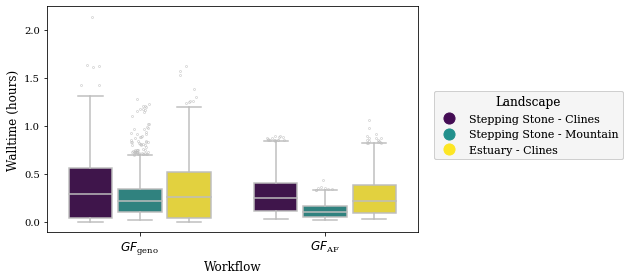

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_glevel_under_source.pdf


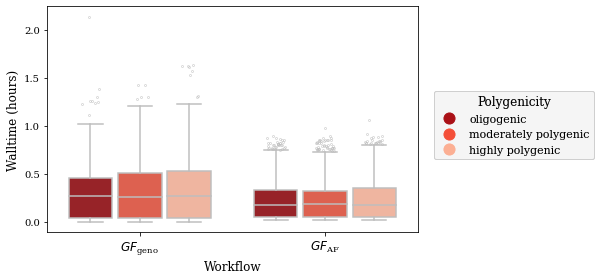

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_pleio_under_source.pdf


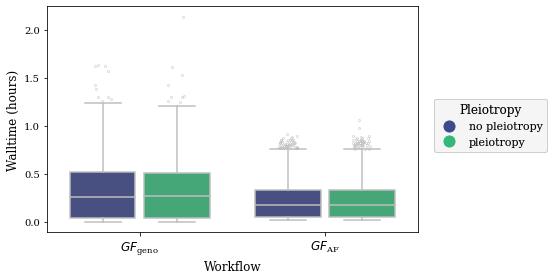

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_slevel_under_source.pdf


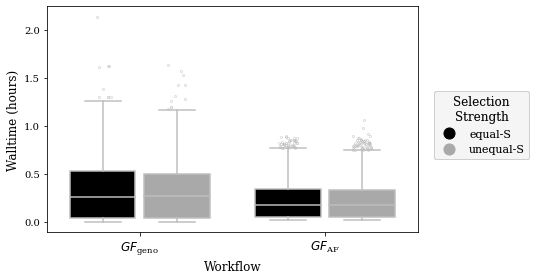

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_popsize_under_source.pdf


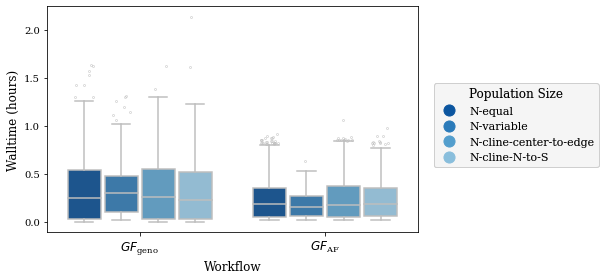

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_migration_under_source.pdf


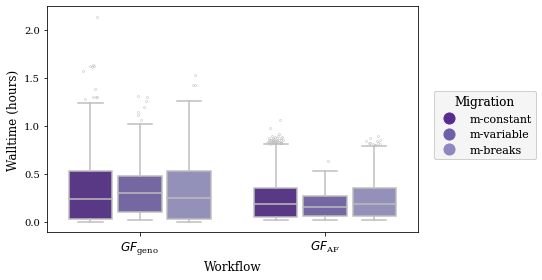

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_num_loci_under_source.pdf


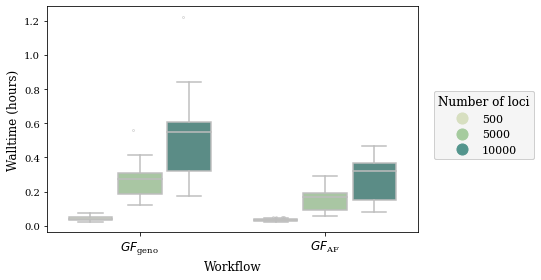

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_final_la_bin_under_source.pdf


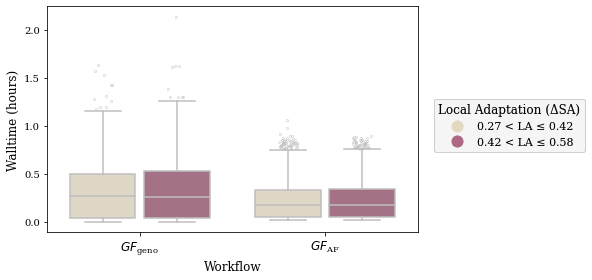

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_source.pdf


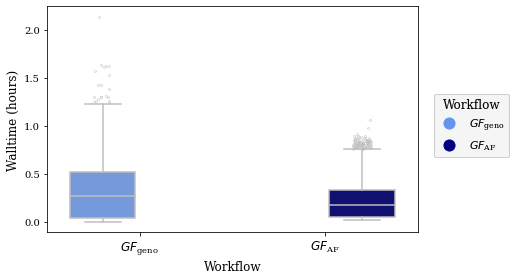

In [38]:
nest_hue_under_source(data=fitting_df, y='walltime_hrs', ylabel='Walltime (hours)')

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_landscape.pdf


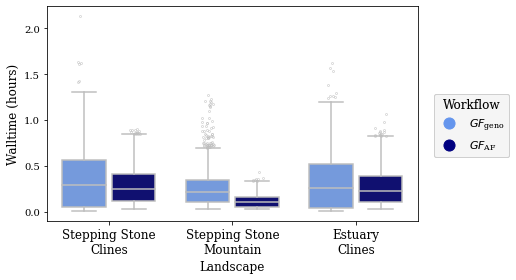

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_glevel.pdf


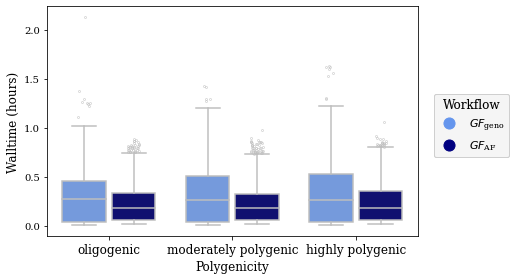

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_pleio.pdf


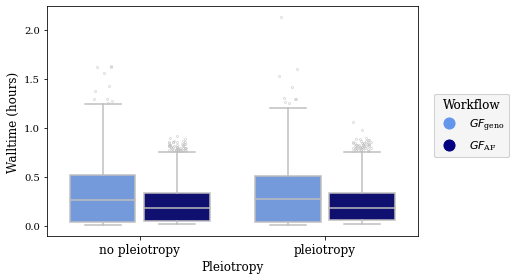

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_slevel.pdf


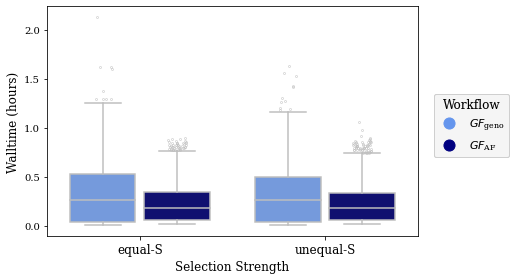

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_popsize.pdf


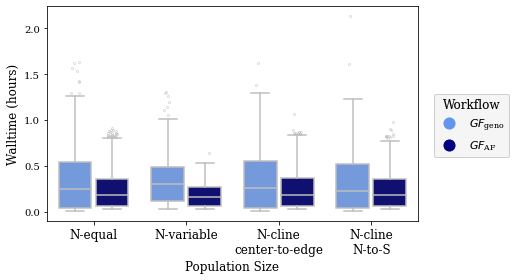

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_migration.pdf


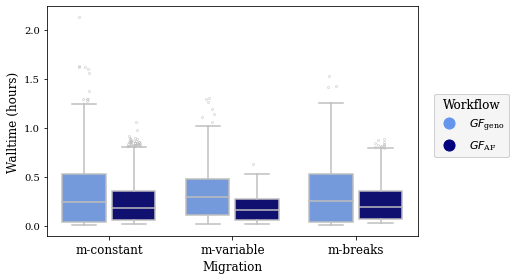

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_num_loci.pdf


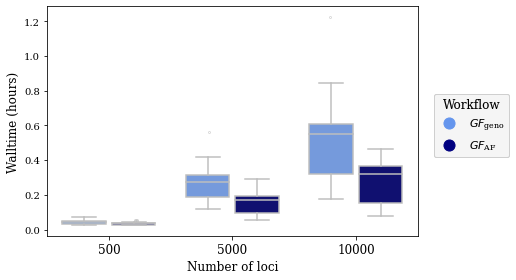

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_final_la_bin.pdf


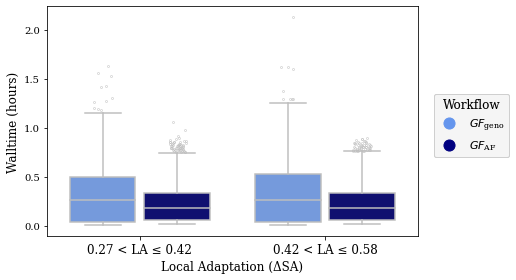

Saved to:  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_walltime_hrs_model_under_model.pdf


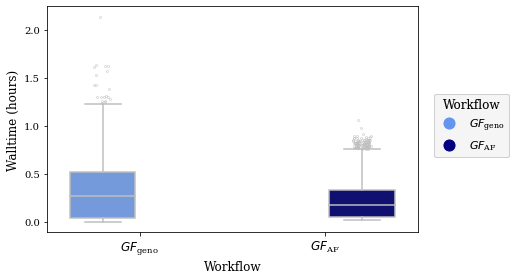

In [39]:
nest_source_under_hue(data=fitting_df, y='walltime_hrs', ylabel='Walltime (hours)')

<a id='fsave'></a>
## save fitting data

[top](#home)

In [40]:
fitting_file = f'{fig_dir}/fitting_seff_df.txt'

fitting_df.to_csv(
    fitting_file,
    sep='\t',
    index=False,  # index is slurm_job_id
    header=True
)

fitting_file

'/work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_seff_df.txt'

In [41]:
fitting_pkl = f'{fig_dir}/fitting_seffs.pkl'

pkldump(fitseffs, fitting_pkl)

fitting_pkl

'/work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_seffs.pkl'

### make sure saved files make sense

In [42]:
for f in fs(fig_dir, endswith='.txt'):
    !md5sum $f

7c74ce5500b4def4d810784ccacfe9e8  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_seff_df.txt
fba2e99c5b41dd64b84e70713799500f  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_seff_df.txt


In [43]:
for f in fs(fig_dir, endswith='.pkl'):
    !md5sum $f

78e09615e15c28f5bb904de10bbd2144  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/fitting_seffs.pkl
95cc2508f3419b0de14a463c80523a1d  /work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/training_seffs.pkl


In [44]:
formatclock(dt.now() - t0)

'0-00:05:28'

<a id='comp'></a>

# determine total computation times

[top](#home)

In [9]:
from pythonimports import *

import runtime_API as rt

fig_dir = f'{rt.resdir}/figures/03_Q3_computational_requirements'

lview, dview = get_client(cluster_id='1726844554-uh4i', profile='lotterhos')

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	September 20, 2024 - 11:11:02 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



In [2]:
training_file = f'{fig_dir}/training_seff_df.txt'

df = pd.read_table(training_file)

df.head()

,slurm_job_id,nodes,cpus,core_walltime_hrs,cpu_efficiency,cpu_usage_hrs,memory_used_MB,memory_efficiency,memory_requested_MB,state,walltime_hrs,out,job,sh,source,rep,num_loci,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel,final_la_bin,model
0,40437730,1,1,0.124167,98.66%,0.122500,7823.36,15.64%,50001.92,State: COMPLETED (exit code 0),0.124167,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231109_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231109,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
1,40437731,1,1,0.118056,98.35%,0.116111,6656.00,13.30%,50001.92,State: COMPLETED (exit code 0),0.118056,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231110_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231110,0.493447,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
2,40437732,1,1,0.110556,99.25%,0.109722,6594.56,13.20%,50001.92,State: COMPLETED (exit code 0),0.110556,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231111_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231111,0.501673,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-equal,m-breaks,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
3,40437733,1,1,0.117222,97.87%,0.114722,7116.80,14.24%,50001.92,State: COMPLETED (exit code 0),0.117222,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231112_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231112,0.497658,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-equal,m-constant,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model
4,40437734,1,1,0.121667,97.26%,0.118333,8724.48,17.46%,50001.92,State: COMPLETED (exit code 0),0.121667,/work/lotterhos/brandon/ind_runtimes/run_20220...,1231113_GF_training_ind_all,/work/lotterhos/brandon/ind_runtimes/run_20220...,ind,run_20220919_0-225,500,1231113,0.512199,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-variable,m-variable,Est-Clines_equal-S,0.42 < LA ≤ 0.58,geno-model


In [41]:
times = {}
for source in df.source.unique():
    hrs = df[df.source == source]['core_walltime_hrs'].sum()
    
    days = hrs / 24
    years = days / 365
    
    print(source, round(years, 2), round(days, 2))
    
    times[source] = years
    
1 - (times['pooled'] / times['ind'])

ind 1.14 417.33
pooled 0.5 180.98


0.5663518704455526

In [42]:
mems = {}
for source in df.source.unique():
    mb = df[df.source == source]['memory_used_MB'].sum()
    
    gb = mb / 1024
    tb = gb / 1024
    
    print(source, round(gb, 2), round(tb, 2))
    
    mems[source] = gb
    
1 - (mems['pooled'] / mems['ind'])

ind 218631.34 213.51
pooled 122693.76 119.82


0.4388098185411685

In [38]:
(1 / 1024) / 1024

9.5367431640625e-07

<a id='proc'></a>
# determine processor information

[top](#home)

In [20]:
shutil.which('sacct')

'/usr/bin/sacct'

In [23]:
df.iloc[0]['slurm_job_id']

40437730

In [45]:
def node_info(jobid):
    """Get node name for the node that ran the job for `jobid`."""
    import subprocess
    import shutil
    
    output = subprocess.check_output(
        [
            shutil.which('sacct'),
            '-j',
            str(jobid),
            '-p',
            '--format=nodelist'
            
        ]
    ).decode('utf-8').split('\n')
    
    output = [x.replace('|', '') for x in output if (x.startswith('NodeList') is False) and (x != '')]
    
    return list(set(output))

In [46]:
x = node_info(df.iloc[0]['slurm_job_id'])

x

['c0566']

In [47]:
jobs = []
for slurm_job_id in df.slurm_job_id:
    jobs.append(
        lview.apply_async(
            node_info, slurm_job_id
        )
    )
    
watch_async(jobs)

nodes = uni(flatten([j.r for j in jobs]))

len(nodes)


Watching 4320 jobs ...


100%|███████████████| 4320/4320 [01:36<00:00, 44.90it/s]


368

In [48]:
fig_dir

'/work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements'

In [50]:
pkl = f'{fig_dir}/node_list.pkl'

pkldump(nodes, pkl)

pkl

'/work/lotterhos/brandon/runtime/figures/03_Q3_computational_requirements/node_list.pkl'

In [82]:
# should have done 'echo $HOSTNAME' instead of echo {node}
shdir = makedir(f'{fig_dir}/shfiles')

shfiles = []
for node in nodes.keys():
    job = f'{node}_cpu_info'
    text = f'''#!/bin/bash
#SBATCH --job-name={job}
#SBATCH --time=1:00:00
#SBATCH --mem=400M
#SBATCH --partition=short
#SBATCH --output=%x_%j.out
#SBATCH --nodelist={node}

echo {node}

echo $HOSTNAME

echo $(lscpu)

'''
    
    shfile = f'{shdir}/{job}.sh'
    with open(shfile, 'w') as o:
        o.write(text)
    shfiles.append(shfile)
    
len(shfiles)

368

In [83]:
print(text)

#!/bin/bash
#SBATCH --job-name=c0226_cpu_info
#SBATCH --time=1:00:00
#SBATCH --mem=400M
#SBATCH --partition=short
#SBATCH --output=%x_%j.out
#SBATCH --nodelist=c0226

echo c0226

echo $HOSTNAME

echo $(lscpu)




In [85]:
Squeue(exclude='bash').cancel()

scancel: 100%|███████████████| 217/217 [00:17<00:00, 12.09it/s]


In [86]:
pids = []
badsh = []
for shfile in pbar(shfiles):
    try:
        pid = sbatch(shfile, progress_bar=False)[0]
        pids.append(pid)
    except:  # when the node name doesn't exist
        print(op.basename(shfile))
        badsh.append(shfile)
        pass

len(pids), len(shfiles)

 11%|█▌             | 39/368 [00:07<00:57,  5.71it/s]sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
 11%|█▋             | 41/368 [00:09<02:36,  2.09it/s]

!!!REACHED FAILCOUNT LIMIT OF 10!!!
d0037_cpu_info.sh


 20%|██▉            | 72/368 [00:15<00:58,  5.05it/s]sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
 20%|███            | 74/368 [00:17<02:32,  1.93it/s]

!!!REACHED FAILCOUNT LIMIT OF 10!!!
d3038_cpu_info.sh


 23%|███▍           | 83/368 [00:19<01:02,  4.57it/s]sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
sbatch: error: Batch job submission failed: Requested nodes not in this partition
 23%|███▍           | 85/368 [00:20<02:31,  1.87it/s]

!!!REACHED FAILCOUNT LIMIT OF 10!!!
d3037_cpu_info.sh


 56%|████████▍      | 207/368 [00:46<00:34,  4.64it/s]sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
 57%|████████▌      | 209/368 [00:48<01:31,  1.75it/s]

!!!REACHED FAILCOUNT LIMIT OF 10!!!
d0039_cpu_info.sh


 62%|█████████▎     | 228/368 [00:53<00:30,  4.53it/s]sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
 62%|█████████▎     | 229/368 [00:55<01:41,  1.36it/s]

!!!REACHED FAILCOUNT LIMIT OF 10!!!
d0005_cpu_info.sh


 89%|█████████████▎ | 327/368 [01:19<00:09,  4.44it/s]sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
sbatch: error: Batch job submission failed: Invalid node name specified
 89%|█████████████▎ | 328/368 [01:21<00:29,  1.36it/s]

!!!REACHED FAILCOUNT LIMIT OF 10!!!
d0007_cpu_info.sh


100%|███████████████| 368/368 [01:30<00:00,  4.05it/s]


(362, 368)

In [172]:
sq = Squeue(grepping='ReqNodeNotAvail')

sq.statuses()

44349725    (ReqNodeNotAvail, UnavailableNodes:c2002)
44349724    (ReqNodeNotAvail, UnavailableNodes:c0241)
44349710    (ReqNodeNotAvail, UnavailableNodes:c0246)
44349690    (ReqNodeNotAvail, UnavailableNodes:c0216)
44349688    (ReqNodeNotAvail, UnavailableNodes:c0188)
44349685    (ReqNodeNotAvail, UnavailableNodes:d0147)
44350037    (ReqNodeNotAvail, UnavailableNodes:c0626)
44350013    (ReqNodeNotAvail, UnavailableNodes:c0240)
44350004    (ReqNodeNotAvail, UnavailableNodes:c2201)
44349999    (ReqNodeNotAvail, UnavailableNodes:c0674)
44349992    (ReqNodeNotAvail, UnavailableNodes:c0423)
44349991    (ReqNodeNotAvail, UnavailableNodes:c0179)
44349966    (ReqNodeNotAvail, UnavailableNodes:c2001)
44349964    (ReqNodeNotAvail, UnavailableNodes:c0242)
44349920    (ReqNodeNotAvail, UnavailableNodes:c0251)
44349880    (ReqNodeNotAvail, UnavailableNodes:c0244)
44349873    (ReqNodeNotAvail, UnavailableNodes:c0281)
44349870    (ReqNodeNotAvail, UnavailableNodes:c2000)
44349869    (ReqNodeNotAvail

In [87]:
sq = Squeue(grepping='ReqNodeNotAvail')

sq.statuses()

44349690    (ReqNodeNotAvail, UnavailableNodes:c0216)
44349688    (ReqNodeNotAvail, UnavailableNodes:c0188)
44349685    (ReqNodeNotAvail, UnavailableNodes:d0147)
44350037    (ReqNodeNotAvail, UnavailableNodes:c0626)
44350013    (ReqNodeNotAvail, UnavailableNodes:c0240)
44350004    (ReqNodeNotAvail, UnavailableNodes:c2201)
44349999    (ReqNodeNotAvail, UnavailableNodes:c0674)
44349992    (ReqNodeNotAvail, UnavailableNodes:c0423)
44349991    (ReqNodeNotAvail, UnavailableNodes:c0179)
44349966    (ReqNodeNotAvail, UnavailableNodes:c2001)
44349964    (ReqNodeNotAvail, UnavailableNodes:c0242)
44349920    (ReqNodeNotAvail, UnavailableNodes:c0251)
44349880    (ReqNodeNotAvail, UnavailableNodes:c0244)
44349873    (ReqNodeNotAvail, UnavailableNodes:c0281)
44349870    (ReqNodeNotAvail, UnavailableNodes:c2000)
44349869    (ReqNodeNotAvail, UnavailableNodes:c0248)
44349866    (ReqNodeNotAvail, UnavailableNodes:c2003)
44349856    (ReqNodeNotAvail, UnavailableNodes:c0630)
44349849    (ReqNodeNotAvail

In [93]:
sq['44349710']

{'pid': '44349710', 'user': 'b.lind', 'account': 'lotterhos', 'job': 'c0246_cpu_info', 'state': 'PD', 'start': 'N/A', 'time': '1:00:00', 'nodes': '1', 'cpus': '1', 'tres_p': 'N/A', 'memory': '400M', 'nodelist': [], 'status': '(ReqNodeNotAvail, UnavailableNodes:c0246)', 'partition': 'short'}

In [89]:
for sh in uni(badsh):
    print(op.basename(sh))
    
# d3038 and d3037 are lotterhos cpus - see above
# the other nodes returned this error when running `srun -w {node} --pty /bin/bash
    # srun: error: Unable to allocate resources: Invalid node name specified

d3038_cpu_info.sh
d0039_cpu_info.sh
d0005_cpu_info.sh
d3037_cpu_info.sh
d0007_cpu_info.sh
d0037_cpu_info.sh


In [1]:
from pythonimports import *

import runtime_API as rt

fig_dir = f'{rt.resdir}/figures/03_Q3_computational_requirements'
shdir = f'{fig_dir}/shfiles'

lview, dview = get_client(cluster_id='1727183433-49gx', profile='lotterhos')

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	September 24, 2024 - 09:12:55 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



In [2]:
# from d3038

# Architecture:          x86_64
# CPU op-mode(s):        32-bit, 64-bit
# Byte Order:            Little Endian
# CPU(s):                36
# On-line CPU(s) list:   0-35
# Thread(s) per core:    1
# Core(s) per socket:    18
# Socket(s):             2
# NUMA node(s):          2
# Vendor ID:             GenuineIntel
# CPU family:            6
# Model:                 85
# Model name:            Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz
# Stepping:              4
# CPU MHz:               999.932
# CPU max MHz:           3700.0000
# CPU min MHz:           1000.0000
# BogoMIPS:              4600.00
# Virtualization:        VT-x
# L1d cache:             32K
# L1i cache:             32K
# L2 cache:              1024K
# L3 cache:              25344K
# NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34
# NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35
# Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch epb cat_l3 cdp_l3 invpcid_single intel_ppin intel_pt ssbd mba ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm mpx rdt_a avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local dtherm ida arat pln pts pku ospke md_clear spec_ctrl intel_stibp flush_l1d arch_capabilities

d3038 = [
    'Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz',
    'Stepping: 4',
    'CPU_MHz: 999.932',
    'CPU_max_MHz: 3500.0000',
    'CPU_min_MHz: 1200.0000'
]

In [3]:
# from d3037

# Architecture:          x86_64
# CPU op-mode(s):        32-bit, 64-bit
# Byte Order:            Little Endian
# CPU(s):                36
# On-line CPU(s) list:   0-35
# Thread(s) per core:    1
# Core(s) per socket:    18
# Socket(s):             2
# NUMA node(s):          2
# Vendor ID:             GenuineIntel
# CPU family:            6
# Model:                 85
# Model name:            Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz
# Stepping:              4
# CPU MHz:               1000.073
# CPU max MHz:           3700.0000
# CPU min MHz:           1000.0000
# BogoMIPS:              4600.00
# Virtualization:        VT-x
# L1d cache:             32K
# L1i cache:             32K
# L2 cache:              1024K
# L3 cache:              25344K
# NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34
# NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35
# Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch epb cat_l3 cdp_l3 invpcid_single intel_ppin intel_pt ssbd mba ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm cqm mpx rdt_a avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local dtherm ida arat pln pts pku ospke md_clear spec_ctrl intel_stibp flush_l1d arch_capabilities

d3037 = [
    'Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz',
    'Stepping: 4',
    'CPU_MHz: 1000.073',
    'CPU_max_MHz: 3700.0000',
    'CPU_min_MHz: 1000.0000'
]

In [28]:
# RERUN once all are done
replacements = [
    ('CPU op-mode(S):' , 'CPU_op-mode(S):'),
    ('Byte Order:', 'Byte_Order:'),
    ('On-line CPU(s) list:', 'On-line_CPU(s)_list:'),
    ('Thread(s) per core:', 'Thread(s)_per_core:'),
    ('Core(s) per socket:', 'Core(s)_per_socket:'),
    ('NUMA node(s):', 'NUMA_node(s):'),
    ('Vendor ID:', 'Vendor_ID:'),
    ('CPU family:', 'CPU_family:'),
    ('Model name:', 'Model_name:'),
    ('CPU MHz:', 'CPU_MHz:'),
    ('CPU max MHz:', 'CPU_max_MHz:'),
    ('CPU min MHz:', 'CPU_min_MHz:'),
    ('L1d cache:', 'L1d_cache:'),
    ('L1 cache:', 'L1i_cache:'),
    ('L2 cache:', 'L2_cache:'),
    ('L3 cache:', 'L3_cache:'),
    ('NUMA node0 CPU(s):', 'NUMA_node0_CPU(s):'),
    ('NUMA node1 CPU(s):', 'NUMA_node1_CPU(s):')
]

outs = fs(shdir, endswith='.out')

models = {}
model_counter = Counter()
nodes_per_model = Counter()
for out in outs:
    node = op.basename(out).split('_')[0]
    
    text = read(out, lines=True)[2]
    
    for replacement in replacements:
        text = text.replace(*replacement)
        
    splits = text.split()[27:45]
    
    assert splits[0] == 'Model_name:'
    
    join = []
    subjoin = []
    for word in splits:
        if word.endswith(':') and word != 'Model_name:':
            join.append(' '.join(subjoin))
            subjoin = []

        subjoin.append(word)

    print('\n%s' % ColorText(node).bold().__str__())
    print('\n'.join(join))
    
    model = join[0]
    if model not in keys(models):
        models[model] = join
        
    model_counter[model] += nodes[node]
    
for node, join in {'d3037' : d3037, 'd3038' : d3038}.items():
    print('\n%s' % ColorText(node).bold().__str__())
    print('\n'.join(join))
    
    model = join[0]
    model_counter[model] += 1
    models[model] = join
    
len(models)


c0165
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 2999.902
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0166
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 1300.000
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0167
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 2999.902
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0170
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 2999.902
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0173
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 1292.700
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0174
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 1369.665
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0175
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 2999.902
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000

c0176
Model_name: Intel(R) Xeon(R) CPU E


c0407
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2899.951
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0408
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2799.902
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0409
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1597.851
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0410
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2197.851
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0411
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2849.707
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0412
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1310.302
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0413
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1200.146
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0414
Model_name: Intel(R) Xeon(R) CPU E


c0522
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2858.642
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0523
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1298.291
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0524
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2799.902
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0525
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1299.023
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0526
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2799.902
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0527
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2846.191
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0528
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1207.031
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0529
Model_name: Intel(R) Xeon(R) CPU E

Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1396.582
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0594
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2836.962
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0596
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2835.498
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0597
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1386.328
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0598
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2799.902
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0599
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2580.322
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0600
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1497.949
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0601
Model_name: Intel(R) Xeon(R) CPU E5-2680 


c0682
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2899.951
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0683
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1272.949
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0684
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2799.902
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0685
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1202.050
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0687
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1295.214
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0688
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1394.970
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0690
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 1199.853
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000

c0691
Model_name: Intel(R) Xeon(R) CPU E

6

In [11]:
len(outs)

328

In [30]:
for model_name, model_info in models.items():
    print('\n')
    print(
        ColorText(model_name).bold().__str__() + \
        '\t' + \
        ColorText(str(model_counter[model_name])).bold().green().__str__()
#         \
#         '(' + ColorText(str(nodes[model_name])).bold().green().__str__() + ')'
    )
    print('\n'.join(model_info))



Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz	492
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 2999.902
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000


Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz	2684
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2899.951
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000


Model_name: Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz	143
Model_name: Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz
Stepping: 4
CPU_MHz: 3099.926
CPU_max_MHz: 3600.0000
CPU_min_MHz: 1200.0000


Model_name: Intel(R) Xeon(R) Platinum 8276 CPU @ 2.20GHz	9
Model_name: Intel(R) Xeon(R) Platinum 8276 CPU @ 2.20GHz
Stepping: 7
CPU_MHz: 2200.000
BogoMIPS: 4400.00
Virtualization: VT-x


Model_name: AMD EPYC 7702 64-Core Processor	15
Model_name: AMD EPYC 7702 64-Core Processor
Stepping: 0
CPU_MHz: 1996.372
BogoMIPS: 3992.74
Virtualization: AMD-V
L1d_cache: 32K L1i


Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz	2
Intel(R) Xeon(R

In [34]:
for model_name, model_info in models.items():
    print('\n')
    print(
        ColorText(model_name).bold().__str__()
    )
    print('\n'.join(model_info))



Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Model_name: Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz
Stepping: 2
CPU_MHz: 2999.902
CPU_max_MHz: 3500.0000
CPU_min_MHz: 1200.0000


Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Model_name: Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping: 1
CPU_MHz: 2899.951
CPU_max_MHz: 3300.0000
CPU_min_MHz: 1200.0000


Model_name: Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz
Model_name: Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz
Stepping: 4
CPU_MHz: 3099.926
CPU_max_MHz: 3600.0000
CPU_min_MHz: 1200.0000


Model_name: Intel(R) Xeon(R) Platinum 8276 CPU @ 2.20GHz
Model_name: Intel(R) Xeon(R) Platinum 8276 CPU @ 2.20GHz
Stepping: 7
CPU_MHz: 2200.000
BogoMIPS: 4400.00
Virtualization: VT-x


Model_name: AMD EPYC 7702 64-Core Processor
Model_name: AMD EPYC 7702 64-Core Processor
Stepping: 0
CPU_MHz: 1996.372
BogoMIPS: 3992.74
Virtualization: AMD-V
L1d_cache: 32K L1i


Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz
Intel(R) Xeon(R) Gold 6140 CPU @ 2.

In [13]:
len(Squeue(grepping='ReqNodeNotAvail'))

34

In [15]:
shfiles = fs(shdir, endswith='.sh')

len(shfiles)

368

In [16]:
Squeue(grepping='ReqNodeNotAvail').cancel()

scancel: 100%|███████████████| 34/34 [00:01<00:00, 17.04it/s]


In [33]:
nrow(df) - 3345

975

<a id='end'></a>

# The End

[top](#home)